# **Blue City DataSet**

## Import Dependencies and Images

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from typing import *

Ref = cv.imread('./Dataset/Blue City/city.JPG')  
Pz1 = cv.imread('./Dataset/Blue City/pieces1.JPG')
Pz2 = cv.imread('./Dataset/Blue City/pieces2.JPG')
Pz3 = cv.imread('./Dataset/Blue City/pieces3.JPG')  

## Some Useful Functions

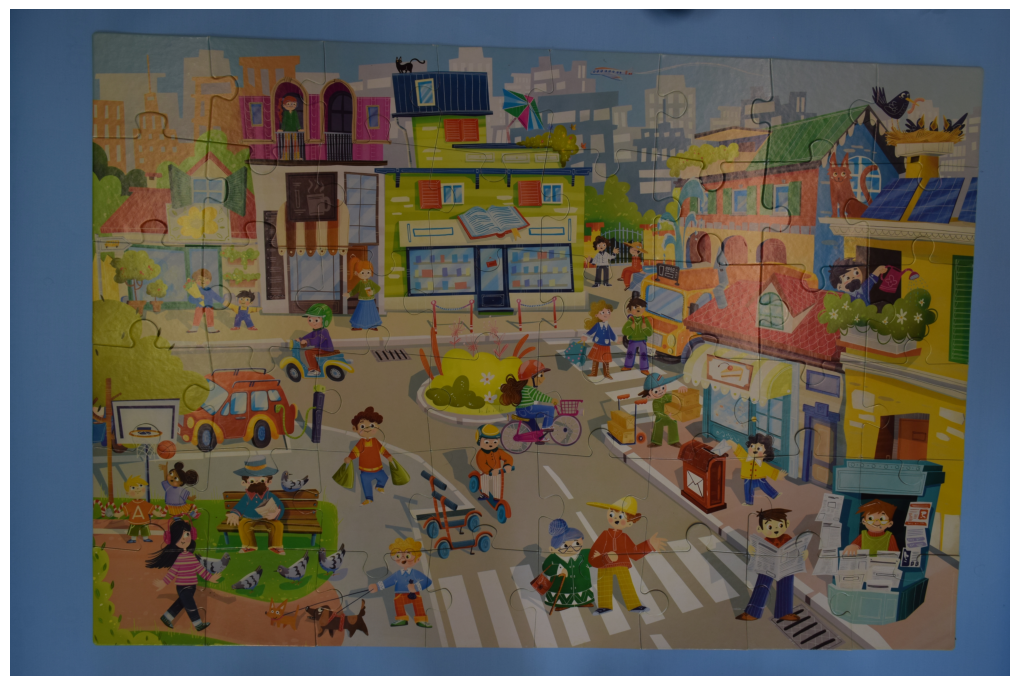

In [2]:
# Func to Show Images using Matplotlib
def ImShow(Im:np.ndarray, FigSize:tuple = (10, 8)) -> None:

    if len(Im.shape) == 3 and Im.shape[2] == 3:
        Im = cv.cvtColor(Im, cv.COLOR_BGR2RGB)
    else:
        Im = cv.cvtColor(Im, cv.COLOR_GRAY2RGB)

    plt.figure(figsize=FigSize)
    plt.imshow(Im)
    plt.axis("off")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.margins(0, 0)
    plt.show()
    
# Example Usage
ImShow(Ref)

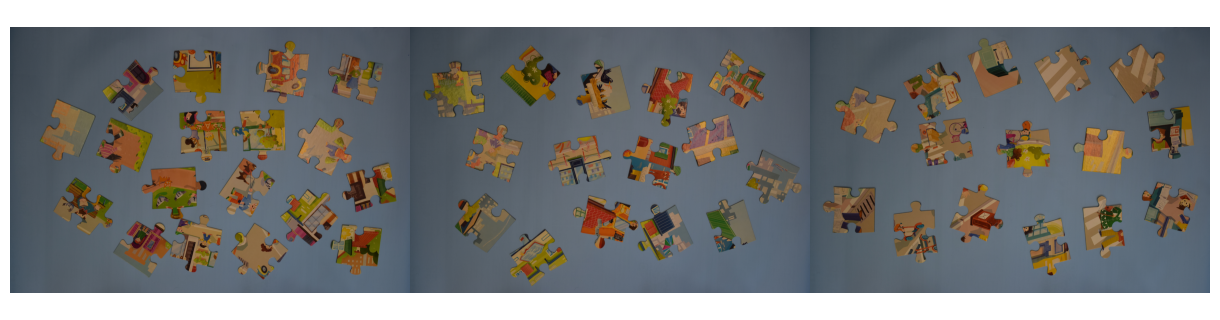

In [3]:
# Func to Plot an Image Grid
def PlotImageGrid(ImageList: list, Rows: int, Cols: int, FigSize: tuple = (20, 16)) -> None:
    plt.figure(figsize=FigSize)
    for idx, Image in enumerate(ImageList):
        if len(Image.shape) == 3 and Image.shape[2] == 3:
            Image = cv.cvtColor(Image, cv.COLOR_BGR2RGB)
        else:
            Image = cv.cvtColor(Image, cv.COLOR_GRAY2BGR)

        plt.subplot(Rows, Cols, idx + 1)
        plt.imshow(Image)
        plt.axis("off")
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.margins(0, 0)

    Canvas = plt.get_current_fig_manager().canvas
    plt.close()
    Canvas.draw()
    PlotImage = np.frombuffer(Canvas.buffer_rgba(), dtype=np.uint8)
    PlotImage = PlotImage.reshape(Canvas.get_width_height()[::-1] + (4,))
    PlotImage = cv.cvtColor(PlotImage, cv.COLOR_RGB2BGR)

    ImShow(PlotImage, FigSize=FigSize)
    
# Example Usage
PlotImageGrid([Pz1, Pz2, Pz3], 1, 3, (12, 3))

In [4]:
# Func to Apply HSV Filter
def ApplyHSVFilter(Im:np.ndarray, Filter:dict) -> Tuple[np.ndarray, np.ndarray]:

    Lower = [Filter["HMin"], Filter["SMin"], Filter["VMin"]]
    Upper = [Filter["HMax"], Filter["SMax"], Filter["VMax"]]
    FilterType = Filter["FilterType"]

    HSV = cv.cvtColor(Im, cv.COLOR_BGR2HSV)
    Msk = cv.inRange(HSV, np.array(Lower), np.array(Upper))
    if FilterType == "Inv Bin": Msk = cv.bitwise_not(Msk)

    return cv.bitwise_and(Im, Im, mask=Msk), Msk

## Segmentation

Pieces Found: 16
Pieces Found: 15
Pieces Found: 15


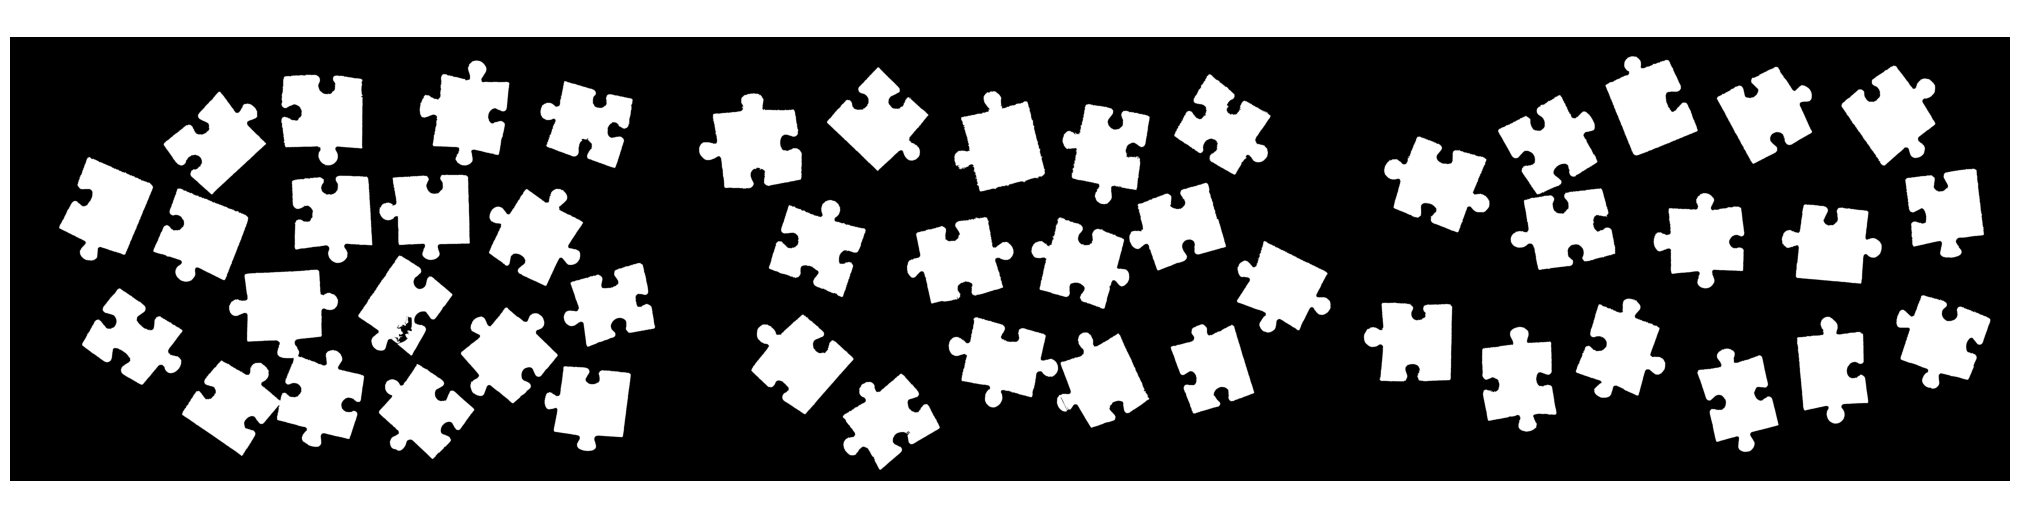

In [5]:
# Create Filters to Separate the BackGround
Filt1 = {'HMin': 100, 'SMin': 34, 'VMin': 59, 'HMax': 113, 'SMax': 91, 'VMax': 134, 'FilterType': 'Inv Bin'}
Filt2 = {'HMin': 100, 'SMin': 34, 'VMin': 59, 'HMax': 113, 'SMax': 91, 'VMax': 134, 'FilterType': 'Inv Bin'}
Filt3 = {'HMin': 100, 'SMin': 34, 'VMin': 72, 'HMax': 113, 'SMax': 91, 'VMax': 134, 'FilterType': 'Inv Bin'}

# Filter Pieces
_, PieceMask1 = ApplyHSVFilter(Pz1, Filt1)
_, PieceMask2 = ApplyHSVFilter(Pz2, Filt2)
_, PieceMask3 = ApplyHSVFilter(Pz3, Filt3)

# Apply Area Size Filter
MinArea = 40000  # in Pixels
PuzzleMasks = []
for PieceMask in [PieceMask1, PieceMask2, PieceMask3]:
    contours, _ = cv.findContours(PieceMask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    PieceMask = np.zeros_like(PieceMask)
    Cnt = 0
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area > MinArea:
            cv.drawContours(PieceMask, [cnt], -1, (255, 255, 255), -1)
            Cnt += 1

    PuzzleMasks.append(PieceMask)
    print(f"Pieces Found: {Cnt}")


# Show the Filtered Masks
PlotImageGrid(PuzzleMasks, 1, 3, (20, 5))

In [6]:
# Separate Segments and Apply Filter to Make Perfect Mask for Pieces
BorderPixels = 10
Masks = []
for PieceMask in PuzzleMasks:
    # Get the Contours
    Cnts, _ = cv.findContours(PieceMask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Separate Pieces in Their Bounding Rectangle
    MaskPieces = []
    for j, Cnt in enumerate(Cnts):

        # Modify the Mask to Only Keep this Contour
        Piece = np.zeros_like(PieceMask)
        cv.drawContours(Piece, [Cnt], -1, (255, 255, 255), -1)

        # Filter1: Only Keep the Biggest Contour
        TmpCnts, _ = cv.findContours(Piece, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        TmpCnts = sorted(TmpCnts, key=cv.contourArea, reverse=True)
        Piece = np.zeros_like(Piece)
        cv.drawContours(Piece, [TmpCnts[0]], -1, (255, 255, 255), -1)

        # Filter2: Fill the Cavities Inside the Pieces
        Kernel = np.ones((15, 15), np.uint8)
        Piece = cv.morphologyEx(Piece, cv.MORPH_CLOSE, Kernel)

        PieceFilled = Piece.copy()
        h, w = PieceFilled.shape[:2]

        # Find Suitable Seed for FloodFill
        Seed = None
        for SourceY in range(PieceFilled.shape[0]):
            for SourceX in range(PieceFilled.shape[1]):
                if PieceFilled[SourceY, SourceX] == 0:
                    Seed = (SourceX, SourceY)
                    break
            if Seed:
                break

        # FloodFill if a Seed Point is Found
        if Seed is not None:
            mask = np.zeros((h+2, w+2), np.uint8)
            cv.floodFill(PieceFilled, mask, Seed, 255)

            InvFilled = cv.bitwise_not(PieceFilled)
            Piece = Piece | InvFilled

        # Save the Piece
        MaskPieces.append(Piece)
        
    Masks += MaskPieces

In [7]:
# Apply the Masks to Get the Pieces
Pieces = []
for i in range(len(Masks)):
    
    if i < 16:    RawPuzzle = Pz1
    elif i < 31:  RawPuzzle = Pz2
    else:         RawPuzzle = Pz3
    
    Pieces.append(cv.bitwise_and(RawPuzzle, RawPuzzle, mask=Masks[i]))

### Working on the Problematic Cluster of Three Pieces

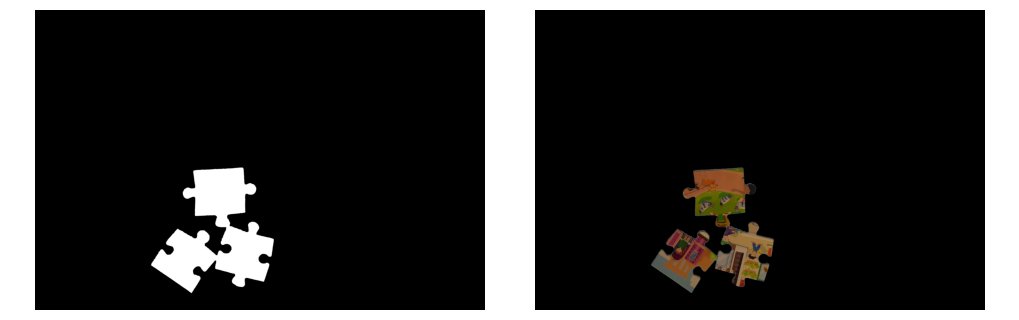

In [8]:
Idx = 4
OrgP = Pieces[Idx]
P = Masks[Idx]

PlotImageGrid([P, OrgP], 1, 2, (10, 3))

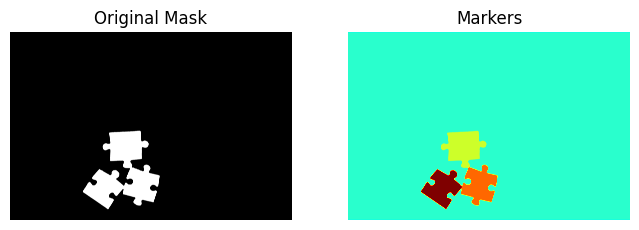

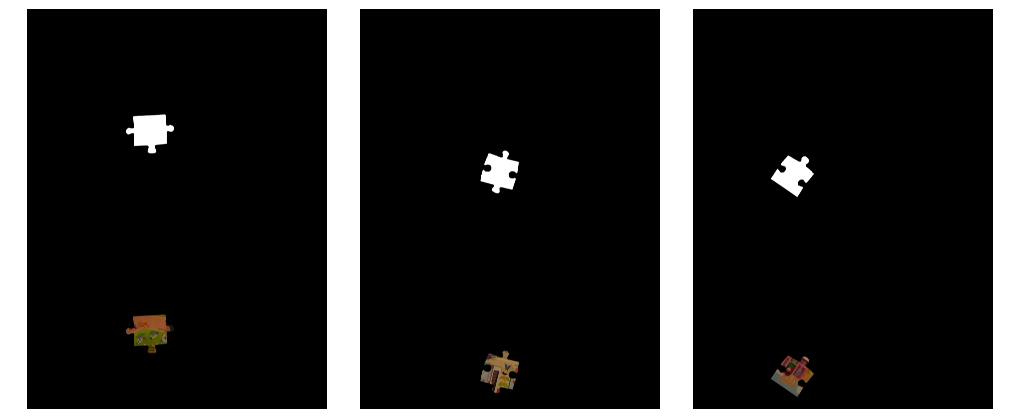

In [9]:
# Sure Foreground (Distance Transform and Threshold)
DistTrans = cv.distanceTransform(P, cv.DIST_L2, 5)
_, ForeGrnd = cv.threshold(DistTrans, 0.15 * DistTrans.max(), 255, 0)
ForeGrnd = np.uint8(ForeGrnd)

# Unknown Region
UnknownRegion = cv.subtract(P, ForeGrnd)

# Marker Labelling
_, Markers = cv.connectedComponents(ForeGrnd)
Markers = Markers + 1
Markers[UnknownRegion == 255] = 0

# Apply Watershed
Markers = cv.watershed(OrgP, Markers)

# Mark boundaries in red on the original image
Final = OrgP.copy()
Final[Markers == -1] = [255, 0, 0]

# Extract individual masks and corresponding parts from the original image
PMasks = []
PieceOrg = []
BorderPixels = 15

for marker in range(2, np.max(Markers) + 1):

    # Create mask for the current marker
    PieceMask = P
    for marker2 in range(2, np.max(Markers) + 1):
        if marker2 != marker:
            TmpMarker = np.uint8(Markers == marker2) * 255
            PieceMask = cv.bitwise_xor(PieceMask, TmpMarker)

    # Remove other markers from the raw mask (P)
    RemainingMask = cv.bitwise_and(P, PieceMask)

    # Remove the Imperfections from the Bitwise XOR
    RemainingMask = cv.erode(RemainingMask, np.ones((15, 15), np.uint8), iterations=1)
    Kernel = np.ones((15, 15), np.uint8)
    RemainingMask = cv.morphologyEx(RemainingMask, cv.MORPH_CLOSE, Kernel)

    # Get the Biggest Contour
    Cnts, _ = cv.findContours(RemainingMask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    TmpCnts = sorted(Cnts, key=cv.contourArea, reverse=True)
    RemainingMask = np.zeros_like(RemainingMask)
    cv.drawContours(RemainingMask, [TmpCnts[0]], -1, (255, 255, 255), -1)

    # Crop mask and corresponding region in the original image
    CroppedMask = RemainingMask
    CroppedOrg = cv.bitwise_and(OrgP, OrgP, mask=CroppedMask)

    # Append to the lists
    PMasks.append(CroppedMask)
    PieceOrg.append(CroppedOrg)

# Display the results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Mask")
plt.imshow(P, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Markers")
plt.imshow(Markers, cmap='jet')
plt.axis('off')
plt.show()

# Display extracted masks and corresponding original parts
PlotImageGrid(PMasks + PieceOrg, 2, 3, (10, 4))

#### Join the pieces

In [10]:
del Masks[Idx]
del Pieces[Idx]

Masks += PMasks
Pieces += PieceOrg

print("Total Masks Detected: ", len(Masks))
print("Total Pieces Detected: ", len(Pieces))

Total Masks Detected:  48
Total Pieces Detected:  48


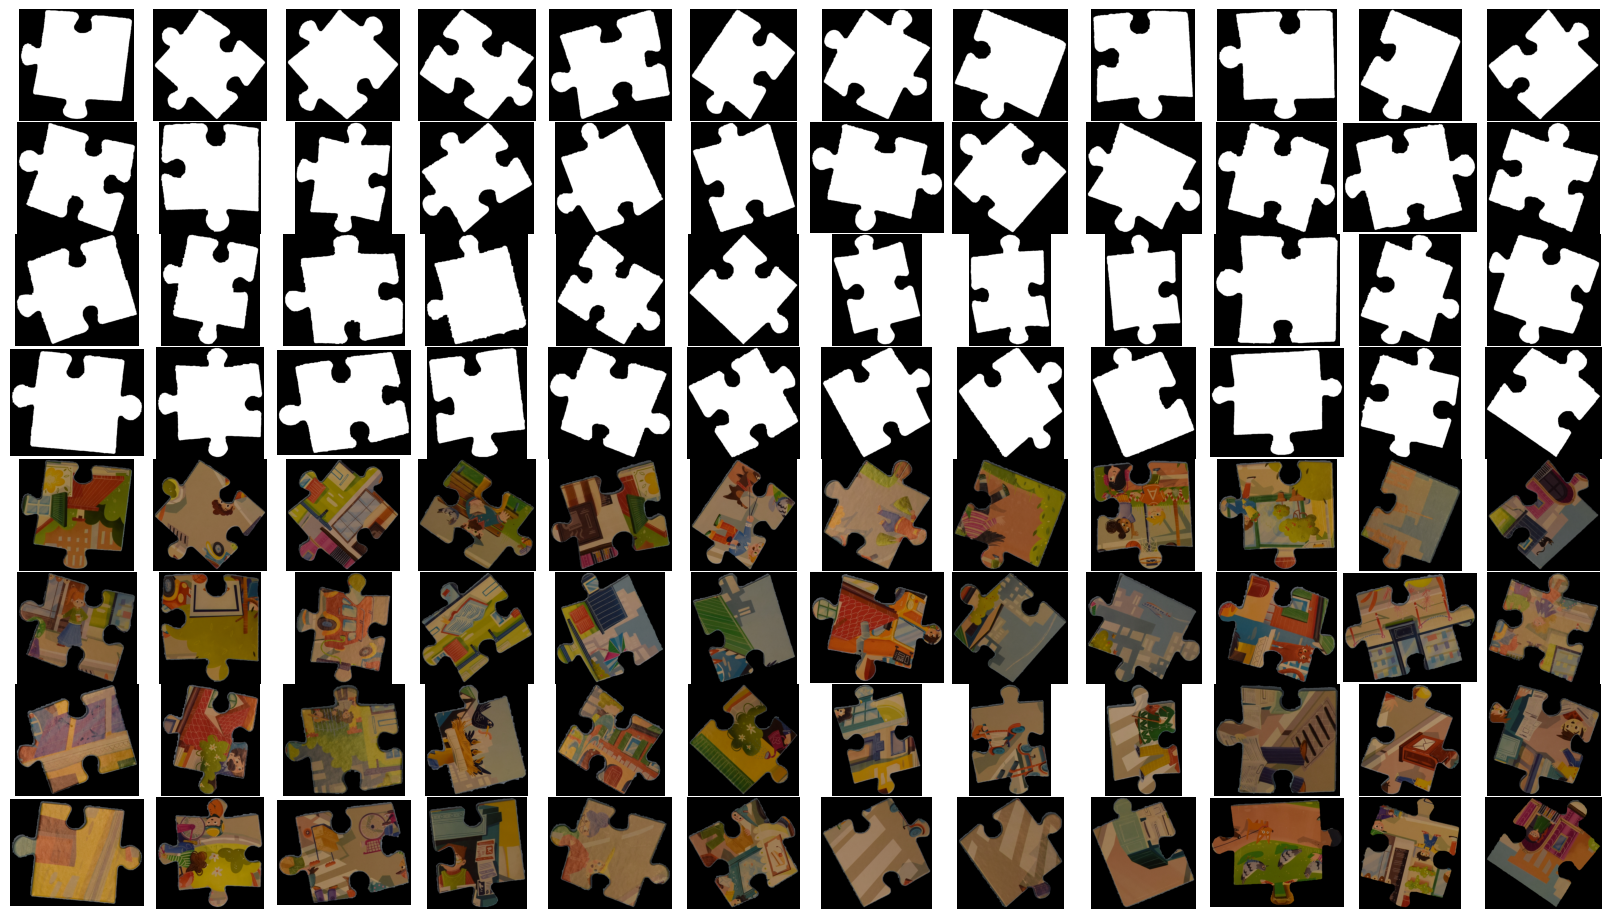

In [11]:
# Plotting the Final Results
CuttedMasks = [] 
CuttedPieces = []
for i in range(len(Masks)):
    # Find the bounding box of the remaining mask
    coords = cv.findNonZero(Masks[i])
    x, y, w, h = cv.boundingRect(coords)

    # Add the border
    Xmin = max(0, x - BorderPixels)
    Ymin = max(0, y - BorderPixels)
    Xmax = min(P.shape[1], x + w + BorderPixels)
    Ymax = min(P.shape[0], y + h + BorderPixels)

    # Crop mask and corresponding region in the original image
    CroppedMask  = Masks[i][Ymin:Ymax, Xmin:Xmax]
    CroppedPiece = Pieces[i][Ymin:Ymax, Xmin:Xmax, :]
    
    CuttedMasks.append(CroppedMask)
    CuttedPieces.append(CroppedPiece)
  
PlotImageGrid(CuttedMasks + CuttedPieces, 8, 12, (16, 9))

# Birds EyeView on the Reference Image

In [12]:
# Apply HSV Filter to Target the Background
RefFilt = {'HMin': 103, 'SMin': 94, 'VMin': 0, 'HMax': 112, 'SMax': 157, 'VMax': 153, 'FilterType': 'Inv Bin'}

# Filter Pieces
_, RefMask = ApplyHSVFilter(Ref, RefFilt)

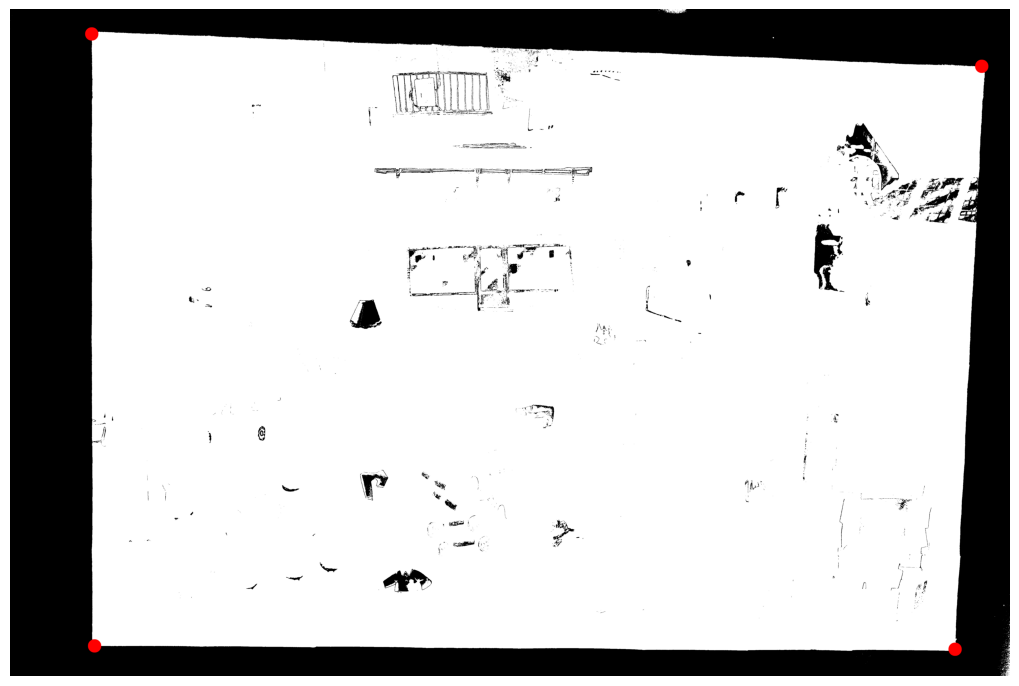

In [13]:
def ProcessMsk(Msk):
    Msk = cv.dilate(Msk, np.ones((5, 5), np.uint8), iterations=1)
    Kernel = np.ones((15, 15), np.uint8)
    Msk = cv.morphologyEx(Msk, cv.MORPH_CLOSE, Kernel)

    Cnts, _ = cv.findContours(Msk, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    TmpCnts = sorted(Cnts, key=cv.contourArea, reverse=True)
    Msk = np.zeros_like(Msk)
    cv.drawContours(Msk, [TmpCnts[0]], -1, (255, 255, 255), -1)

    MskEdge = cv.Canny(Msk, 100, 200)

    Cntr, _ = cv.findContours(MskEdge, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    MaxCntr = max(Cntr, key=cv.contourArea)

    Eps = 0.1 * cv.arcLength(MaxCntr, True)
    Corners = cv.approxPolyDP(MaxCntr, Eps, True)


    return Msk, Corners

TmpMask, Corners = ProcessMsk(RefMask)

MarkedIm = cv.cvtColor(RefMask, cv.COLOR_GRAY2BGR)
for point in Corners:
    x, y = point[0]
    cv.circle(MarkedIm, (x, y), 40, (0, 0, 255), -1)


ImShow(MarkedIm, (10, 10))

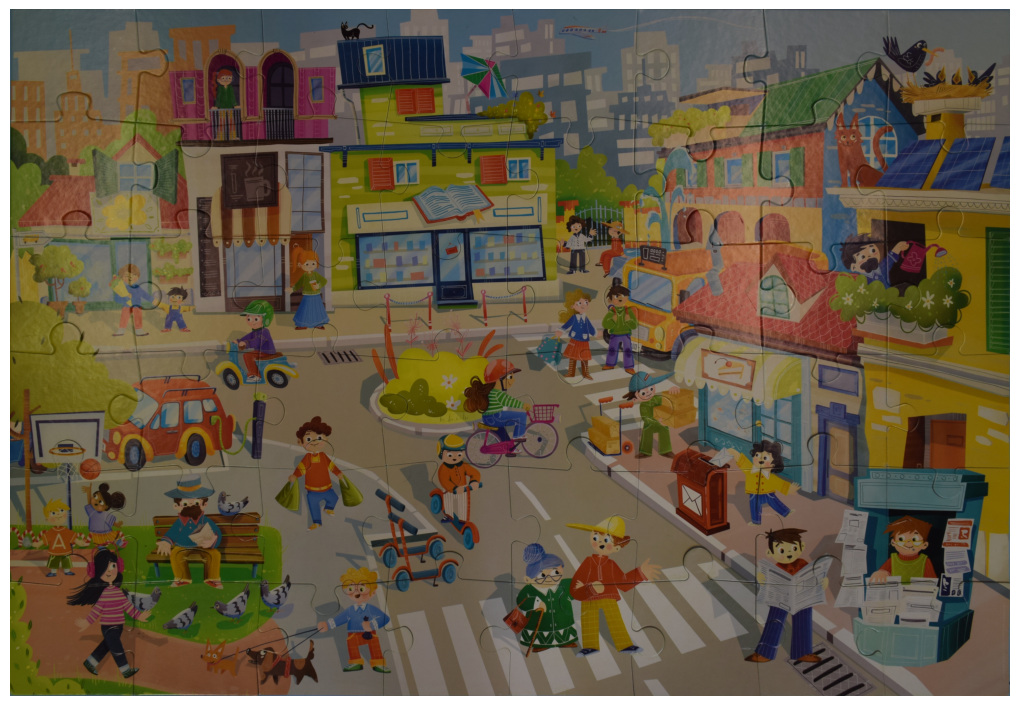

In [14]:
def BirdsEyeView(Im, Corners):
    # Process Corner Points
    Corners = Corners.reshape(4, 2)
    Sums    = Corners.sum(axis=1)
    Diffs   = np.diff(Corners, axis=1)

    TL = Corners[np.argmin(Sums)]       # Top Left
    BR = Corners[np.argmax(Sums)]       # Bottom Right
    TR = Corners[np.argmin(Diffs)]      # Top Right
    BL = Corners[np.argmax(Diffs)]      # Bottom Left

    SortedCrnr = np.array([TL, TR, BL, BR], dtype=np.float32)

    # Destination Points for the Bird's-eye View
    w = int(max(np.linalg.norm(TR - TL), np.linalg.norm(BR - BL)))
    h = int(max(np.linalg.norm(BL - TL), np.linalg.norm(BR - TR)))

    dst_points = np.array([
        [0, 0],                 # Top-left
        [w - 1, 0],             # Top-right
        [0, h - 1],             # Bottom-left
        [w - 1, h - 1]          # Bottom-right
    ], dtype=np.float32)

    # Compute the Perspective Transform Matrix
    Kernel = cv.getPerspectiveTransform(SortedCrnr, dst_points)

    # Apply Perspective Transform
    WarpedIm = cv.warpPerspective(Im, Kernel, (w, h))

    return WarpedIm

Ref = BirdsEyeView(Ref, Corners)
ImShow(Ref, (10, 10))

## Feature Extraction and Matching

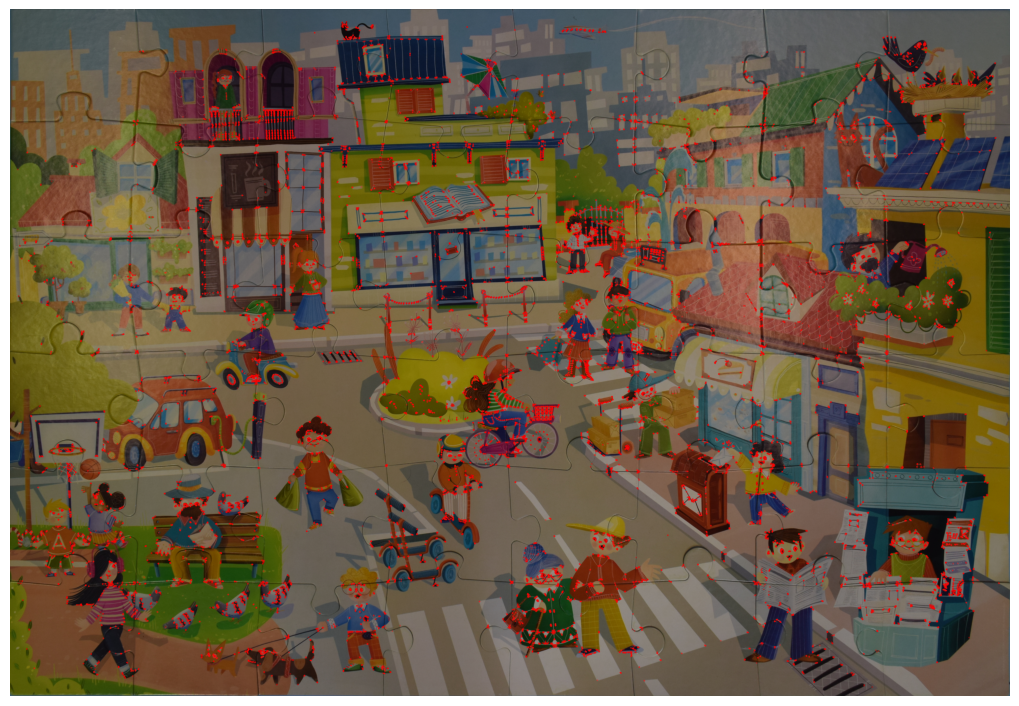

In [15]:
# Create the ORB Obj
ORB = cv.ORB_create(nfeatures=70000)

# Finds the Keypoints and Descriptors for the Reference Image
GrayRef = cv.cvtColor(Ref, cv.COLOR_BGR2GRAY)
RefKeyPoints, RefDescr = ORB.detectAndCompute(GrayRef, None)

# Draw Keypoints on the Reference Image
RefDrawnKP = cv.drawKeypoints(Ref, RefKeyPoints, None, (0, 0, 255))
ImShow(RefDrawnKP)

# Finds the keypoints and descriptors for each piece
PiecesKP = []
PiecesDescr = []
PiecesWithFeatures = []
for i, piece in enumerate(Pieces):
    keypoints, descriptors = ORB.detectAndCompute(piece, None)
    PiecesKP.append(keypoints)
    PiecesDescr.append(descriptors)

# Finds the Correspondences Between the Image Descriptors and the Piece Descr
Ratio = 3
Matches = []
for i, PDescr in enumerate(PiecesDescr): 
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    PieceMtch = bf.match(PDescr, RefDescr)

    # Discard Zeros
    FilteredMatches = [m for m in PieceMtch if m.distance > 0]
    
    # Refines the Matches
    MinDist = min([m.distance for m in FilteredMatches])
    RefinedMatches = [m for m in PieceMtch if m.distance < Ratio * MinDist]
    Matches.append(RefinedMatches)

# Calcul the Affine Transform
AffineTransforms = []
for i, RefinedMatches in enumerate(Matches):
    if len(RefinedMatches) >= 3:
        PieceP = np.float32([PiecesKP[i][m.queryIdx].pt for m in RefinedMatches]).reshape(-1, 1, 2)
        RefP   = np.float32([RefKeyPoints[m.trainIdx].pt for m in RefinedMatches]).reshape(-1, 1, 2)
        
        Trns = cv.estimateAffinePartial2D(PieceP, RefP)[0]
        AffineTransforms.append(Trns)

        if Trns is None: print(f"No valid transformation found for piece {i + 1}")
    
    else:
        print(f"Not enough matches for piece {i + 1} to compute affine transformation.")


## Puzzle Reconstruction

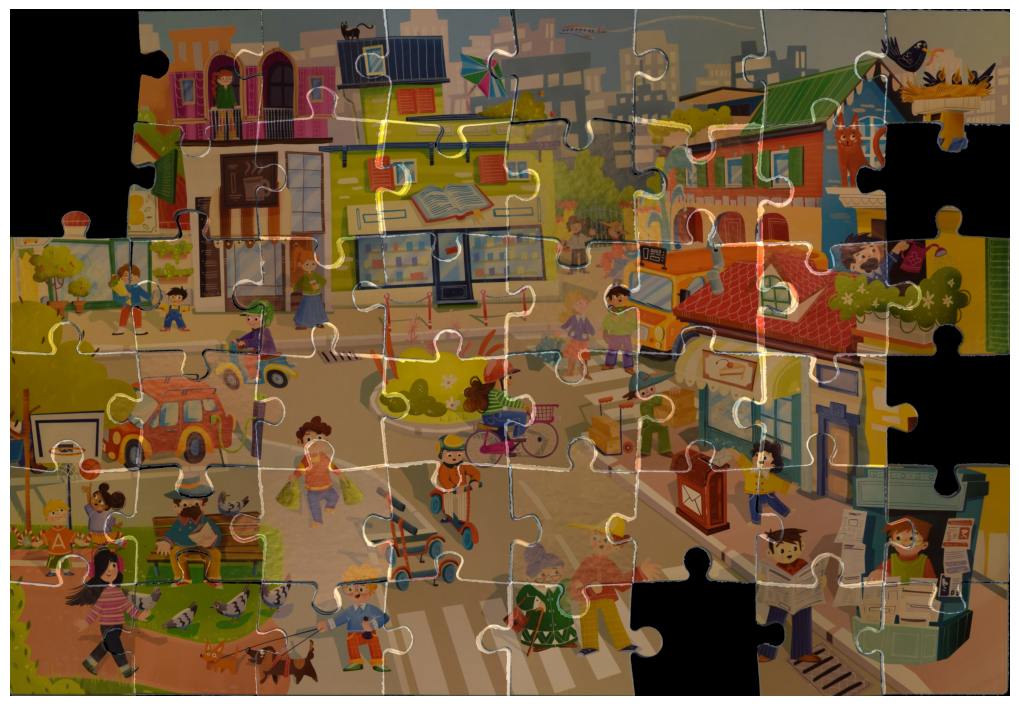

In [16]:
ReconPuzzle = np.zeros_like(Ref)
AvoidList = [43, 0, 36, 24, 10]             # Mismatched Pieces

# Apply the Transforms
for i, Trns in enumerate(AffineTransforms):
    if Trns is not None and i not in AvoidList:
        h, w = Pieces[i].shape[:2]

        WarpedPiece = cv.warpAffine(Pieces[i], Trns, (Ref.shape[1], Ref.shape[0]))
        Msk = np.where(WarpedPiece > 0, 1, 0).astype(np.uint8)
        ReconPuzzle = cv.add(ReconPuzzle, WarpedPiece * Msk)

# Final Puzzle
ImShow(ReconPuzzle)

## Puzzle Reconstruction with Alpha Blending

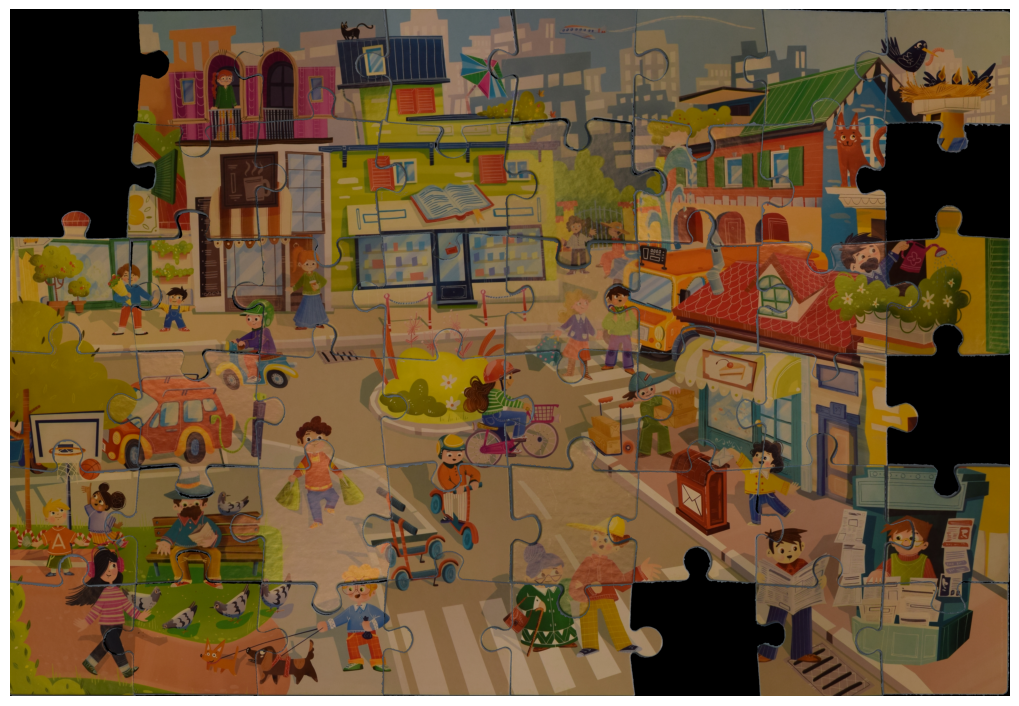

In [17]:
ReconPuzzle = np.zeros_like(Ref)

# Apply the Transforms
for i, Trns in enumerate(AffineTransforms):
    if Trns is not None and i not in AvoidList:
        h, w = Pieces[i].shape[:2]

        WarpedPiece = cv.warpAffine(Pieces[i], Trns, (Ref.shape[1], Ref.shape[0]))
        Msk = np.where(WarpedPiece > 0, 1, 0).astype(np.uint8)

        # Perform Alpha Blending
        region = ReconPuzzle * (1 - Msk) 
        blended_piece = cv.addWeighted(region, 1, WarpedPiece, 1, 0)
        ReconPuzzle = blended_piece

# Final result of the reconstructed puzzle
ImShow(ReconPuzzle)
